### Ejercicio 1

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import math

sys.path.append('/Users/marcosgonzalez/Desktop/Circu/Circulacion-General-FCEN/modulo_oceano')

from funciones.cargar_salida_QG import *
from funciones.calculosCBO import *
from funciones.laplaciano import *

In [2]:
# Directorios de salida para cada modelo
base_dir = '/Users/marcosgonzalez/Desktop/Circu/Practica 2'

dir_salidas = {
    "NL1": f"{base_dir}/out_tmp_NL1/",
    "NL2": f"{base_dir}/out_tmp_NL2/",
    "NL3": f"{base_dir}/out_tmp_NL3/"
}

# Dimensiones del modelo
Lx, Ly = 4000, 2000  # Dimensiones de la cuenca en km
nx, ny = 200, 100    # Puntos de grilla

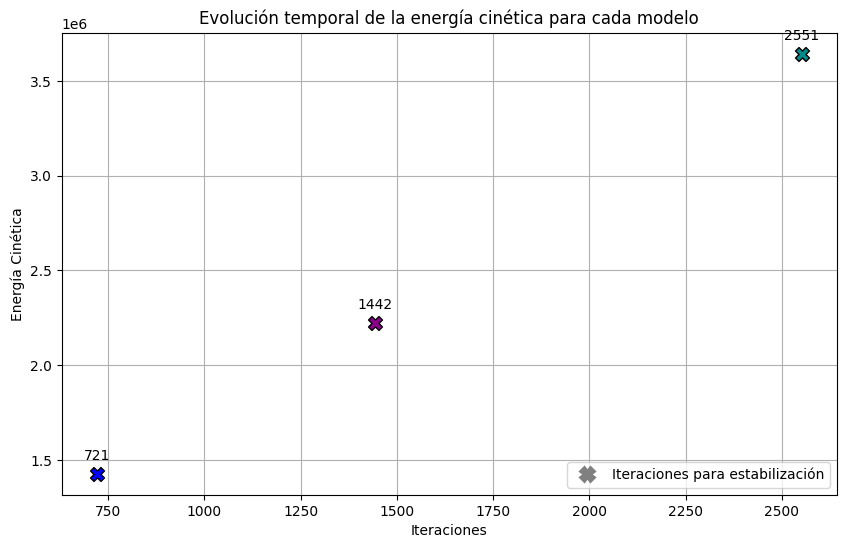

In [3]:
# Carga de datos
NL1 = cargar(dir_salidas["NL1"], 4000, 2000, 200, 100)
NL2 = cargar(dir_salidas["NL2"], 4000, 2000, 200, 100)
NL3 = cargar(dir_salidas["NL3"], 4000, 2000, 200, 100)
QG_diagNL1 = NL1[4][:,3]
QG_diagNL2 = NL2[4][:,3]
QG_diagNL3 = NL3[4][:,3]

# Función para calcular el tiempo de estabilización
def calc_tiempo_estabilizacion(tke):
    ECfinal = tke[-1]
    error_ECfinal = ECfinal / 100  # 1% del valor final como umbral
    i = 1
    while i < len(tke):
        if abs(tke[-i] - ECfinal) < error_ECfinal:
            i += 1
        else:
            TiempoEst = len(tke) - i
            break
    return TiempoEst

estabilizacionNL1 = calc_tiempo_estabilizacion(QG_diagNL1)
estabilizacionNL2 = calc_tiempo_estabilizacion(QG_diagNL2)
estabilizacionNL3 = calc_tiempo_estabilizacion(QG_diagNL3)

plt.figure(figsize=(10, 6)) ## buscar nombre variavle en casa
# plt.plot(tiempoNL1, QG_diagNL1, color='darkcyan', label='NL1')
# plt.plot(tiempoNL2, QG_diagNL2, color='darkmagenta', label='NL2')
# plt.plot(tiempoNL3, QG_diagNL3, label='NL3')

# Puntos de estabilización usando cruces
plt.scatter(estabilizacionNL1, QG_diagNL1[estabilizacionNL1], color='darkcyan', s=100, edgecolor='black', zorder=5, marker='X')
plt.scatter(estabilizacionNL2, QG_diagNL2[estabilizacionNL2], color='darkmagenta', s=100, edgecolor='black', zorder=5, marker='X')
plt.scatter(estabilizacionNL3, QG_diagNL3[estabilizacionNL3], color='blue', s=100, edgecolor='black', zorder=5, marker='X')

plt.plot([], [], 'X', color='grey', label='Iteraciones para estabilización', markersize=10, markeredgewidth=2)

plt.annotate(f"{estabilizacionNL1}", (estabilizacionNL1, QG_diagNL1[estabilizacionNL1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"{estabilizacionNL2}", (estabilizacionNL2, QG_diagNL2[estabilizacionNL2]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"{estabilizacionNL3}", (estabilizacionNL3, QG_diagNL3[estabilizacionNL3]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Iteraciones')
plt.ylabel('Energía Cinética')
plt.title('Evolución temporal de la energía cinética para cada modelo')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [4]:
# Parámetros físicos y de dimensionalización
tau = 0.25          # Tensión del viento [N/m^2]
L = 4000000         # Longitud de la cuenca [m]
D = 2500            # Profundidad [m]
beta = 2e-11        # Coeficiente de Coriolis [1/(s*m)]
rho = 1025          # Densidad [kg/m^3]
K = 1.16e-7
U = (2 * math.pi * tau) / (rho * D * beta * L)  # Velocidad

# Dimensionalización de las variables
psi_NL1_dim = NL1[2] * U * L
psi_NL2_dim = NL2[2] * U * L
psi_NL3_dim = NL3[2] * U * L

vort_NL1_dim = NL1[3] * U / L
vort_NL2_dim = NL2[3] * U / L
vort_NL3_dim = NL3[3] * U / L

In [5]:
def calcular_transporte_meridional_promedio(psi, D):
    """
    Calcula el transporte meridional promediado en la vertical.
    psi: matriz de función corriente
    D: profundidad en metros
    """
    # Derivada zonal de la función corriente multiplicada por la profundidad
    trans_mer = np.diff(psi, n=1, axis=1) * D
    return trans_mer

def plot_campos(X, Y, campo, titulo, xlabel, ylabel, cbar_label, ax=None, vmin=None, vmax=None, colormap='viridis', levels=10, fmt="%.1f"):
    """
    Función genérica para graficar campos 2D con etiquetas.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    # Si levels es un entero, generar los niveles automáticamente
    if isinstance(levels, int):
        level_values = np.linspace(vmin if vmin is not None else np.min(campo), 
                                   vmax if vmax is not None else np.max(campo), levels)
    else:
        level_values = levels
    
    # Graficar con los límites de color especificados y niveles personalizados
    contourf = ax.contourf(X, Y, campo, levels=level_values, cmap=colormap)
    
    # Añadir líneas de contorno sobre el gráfico contourf
    cont = ax.contour(X, Y, campo, levels=level_values, colors='k', linewidths=0.4)
    
    # Aplicar el formato directamente al crear las etiquetas
    ax.clabel(cont, inline=True, fontsize=8, fmt=fmt)
    
    cbar = plt.colorbar(contourf, ax=ax)
    cbar.set_label(cbar_label)
    ax.set_title(titulo)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if ax is None:  # Solo mostrar si se crea una nueva figura
        plt.show()

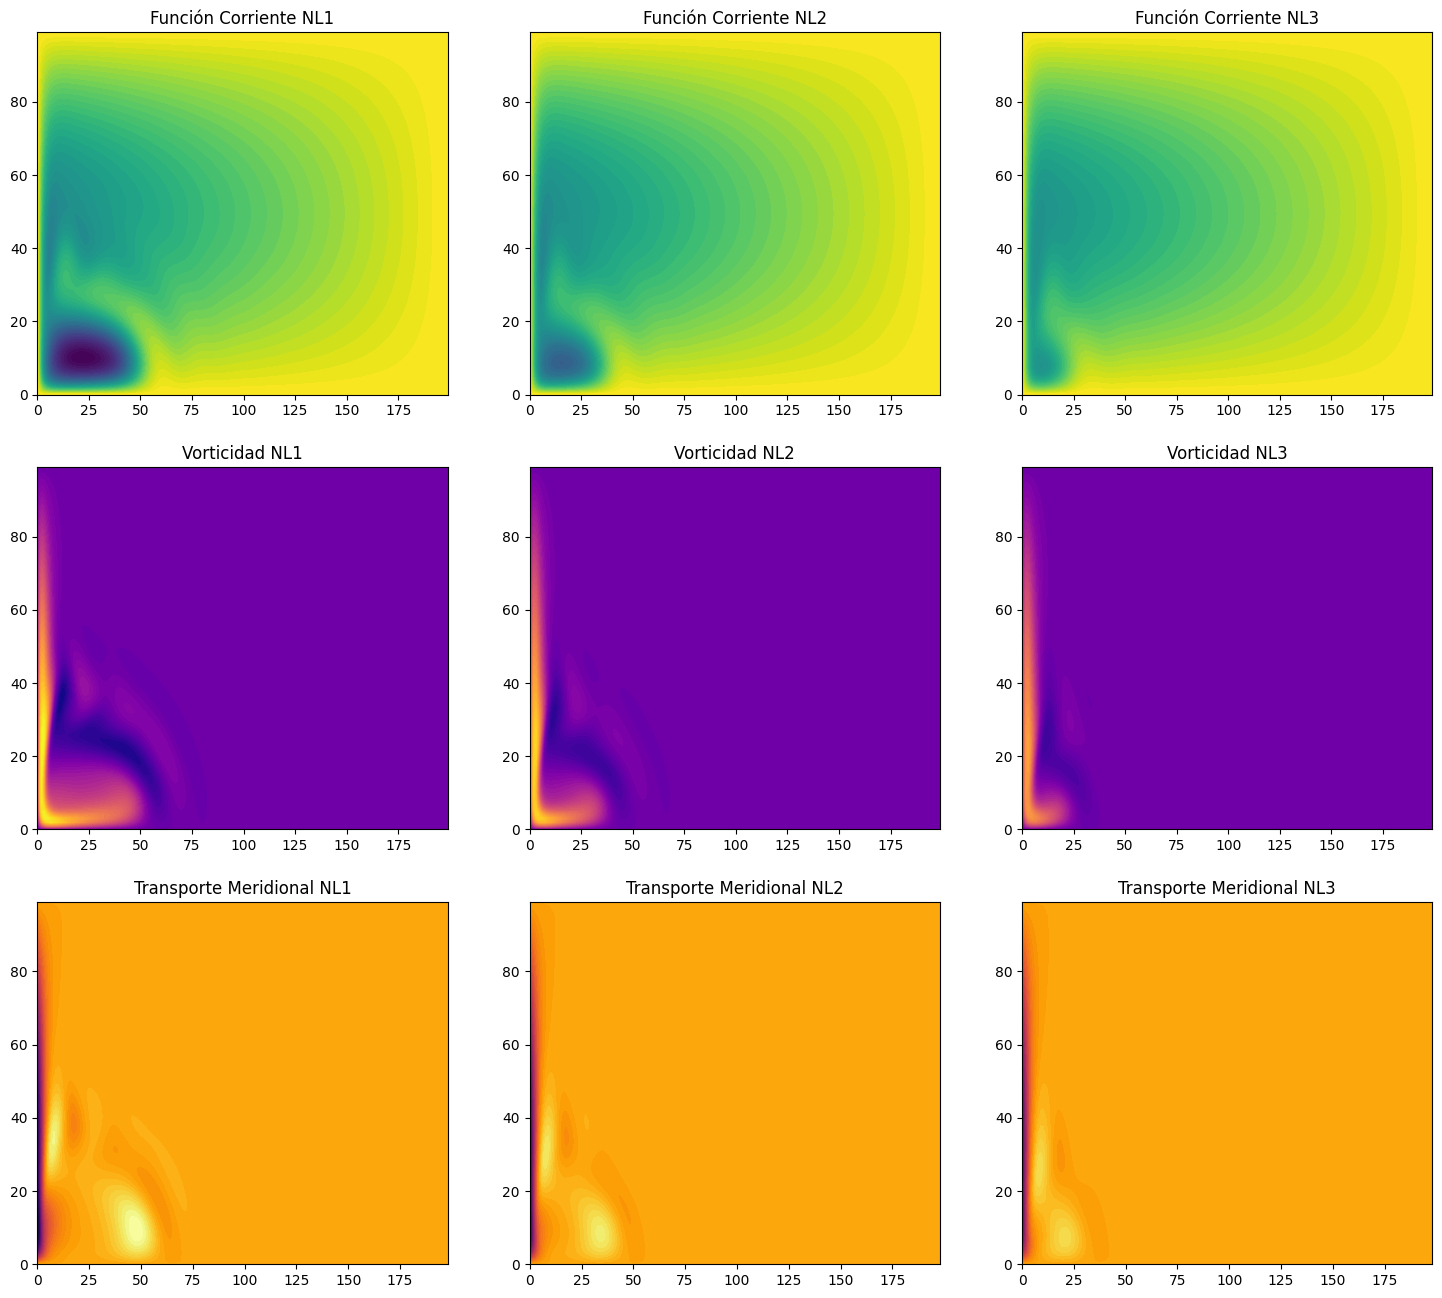

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Dimensionalización de las variables
psi_NL1_dim = NL1[2] * U * L
psi_NL2_dim = NL2[2] * U * L
psi_NL3_dim = NL3[2] * U * L

vort_NL1_dim = NL1[3] * U / L
vort_NL2_dim = NL2[3] * U / L
vort_NL3_dim = NL3[3] * U / L

trans_NL1 = calcular_transporte_meridional_promedio(psi_NL1_dim, D)
trans_NL2 = calcular_transporte_meridional_promedio(psi_NL2_dim, D)
trans_NL3 = calcular_transporte_meridional_promedio(psi_NL3_dim, D)

# Crear una figura y ajustar el número de subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 16))  # 3 filas (psi, vort, trans), 3 columnas (NL1, NL2, NL3)

# Configuración de límites para las colorbars uniformes
psi_min = min(psi.min() for psi in [psi_NL1_dim, psi_NL2_dim, psi_NL3_dim])
psi_max = max(psi.max() for psi in [psi_NL1_dim, psi_NL2_dim, psi_NL3_dim])
vort_min = min(vort.min() for vort in [vort_NL1_dim, vort_NL2_dim, vort_NL3_dim])
vort_max = max(vort.max() for vort in [vort_NL1_dim, vort_NL2_dim, vort_NL3_dim])
trans_min = min(trans.min() for trans in [trans_NL1, trans_NL2, trans_NL3])
trans_max = max(trans.max() for trans in [trans_NL1, trans_NL2, trans_NL3])

# Ploteo de funciones corrientes, vorticidades y transporte meridional
modelos = ["NL1", "NL2", "NL3"]
for idx, (psi_dim, vort_dim, trans) in enumerate(zip([psi_NL1_dim, psi_NL2_dim, psi_NL3_dim], 
                                                     [vort_NL1_dim, vort_NL2_dim, vort_NL3_dim], 
                                                     [trans_NL1, trans_NL2, trans_NL3])):
    cont_psi = axs[0, idx].contourf(psi_dim, levels=np.linspace(psi_min, psi_max, 50), cmap='viridis')
    cont_vort = axs[1, idx].contourf(vort_dim, levels=np.linspace(vort_min, vort_max, 50), cmap='plasma')
    cont_trans = axs[2, idx].contourf(trans, levels=np.linspace(trans_min, trans_max, 50), cmap='inferno')
    axs[0, idx].set_title(f'Función Corriente {modelos[idx]}')
    axs[1, idx].set_title(f'Vorticidad {modelos[idx]}')
    axs[2, idx].set_title(f'Transporte Meridional {modelos[idx]}')




In [12]:
def find_levels(data_array, num_levels=10):
    min_val = np.min(data_array)
    max_val = np.max(data_array)
    return np.linspace(min_val, max_val, num_levels)

corr_levels = find_levels(psi_NL1_dim)
vort_levels = find_levels(vort_NL1_dim)
trans_levels = find_levels(trans_NL1)

## Arreglar escalas

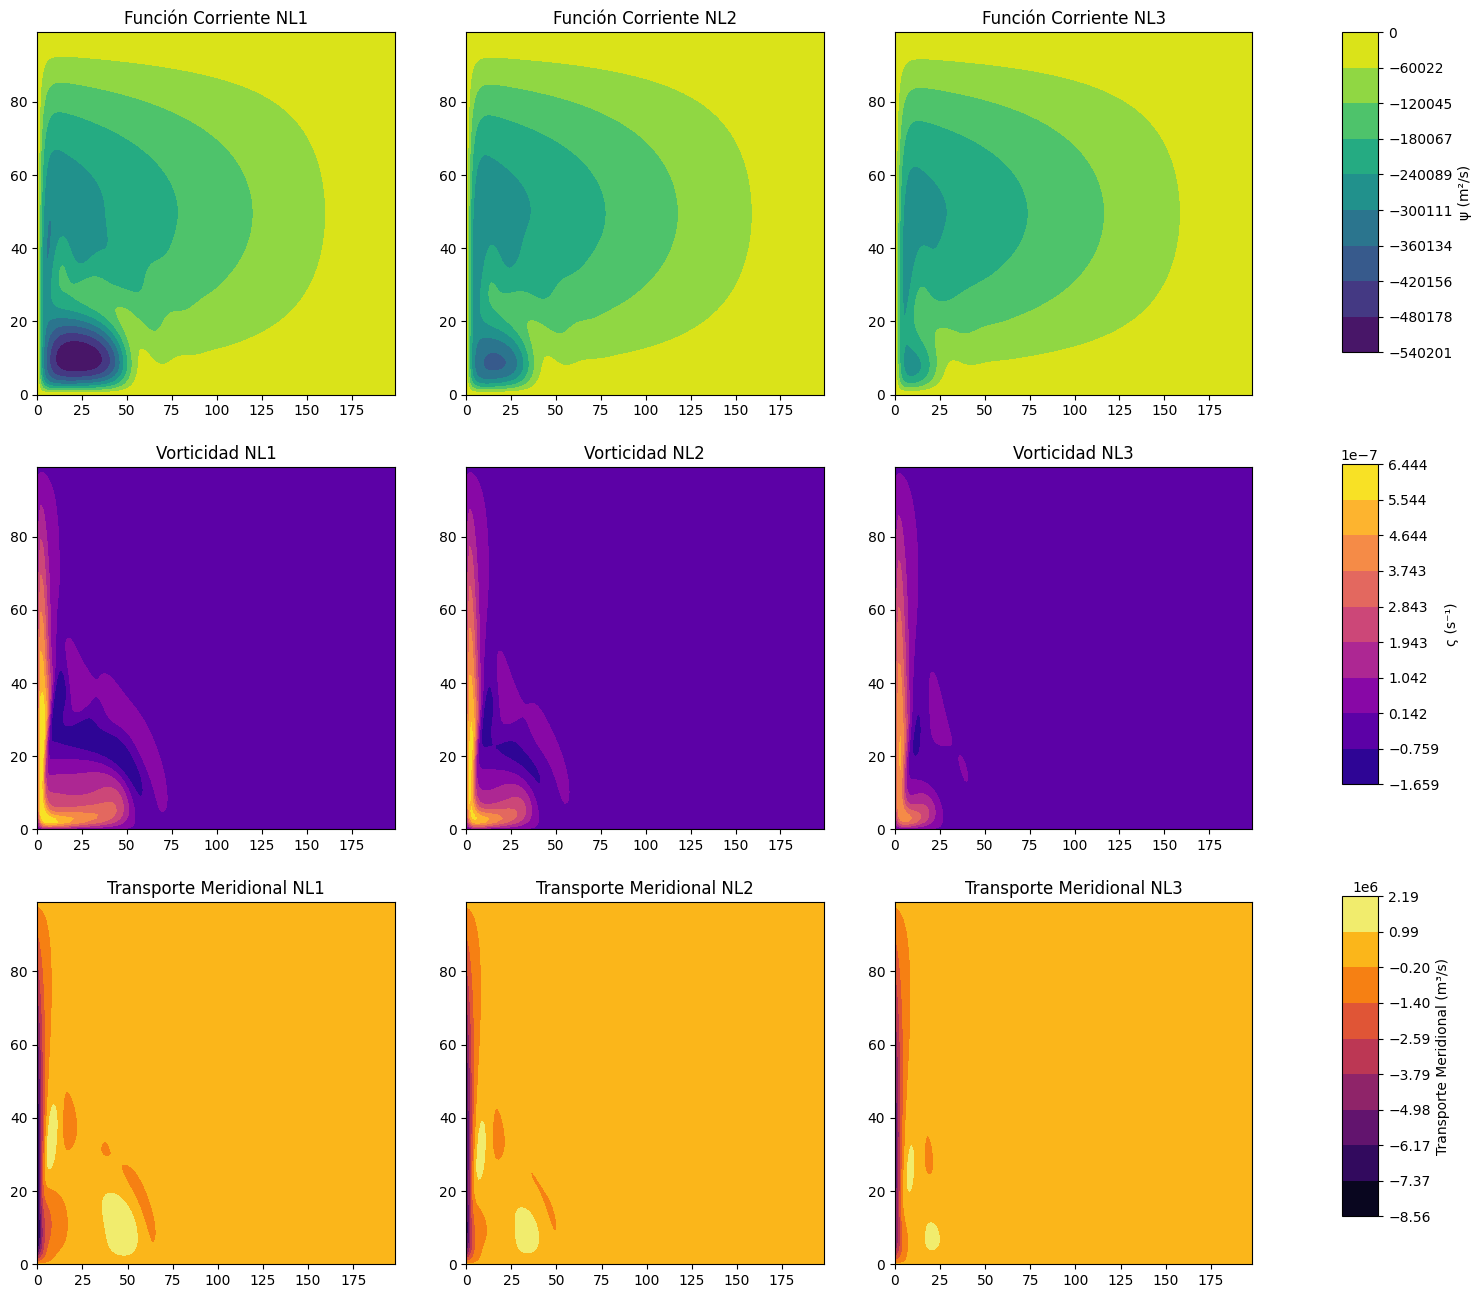

In [13]:
# Función para calcular transporte meridional promediado
def calcular_transporte_meridional_promedio(psi, D):
    """
    Calcula el transporte meridional promediado en la vertical.
    psi: matriz de función corriente
    D: profundidad en metros
    """
    trans_mer = np.diff(psi, n=1, axis=1) * D * U * L / 1e6
    return trans_mer

# Dimensionalización de las variables
psi_NL1_dim = NL1[2] * U * L
psi_NL2_dim = NL2[2] * U * L
psi_NL3_dim = NL3[2] * U * L

vort_NL1_dim = NL1[3] * U / L
vort_NL2_dim = NL2[3] * U / L
vort_NL3_dim = NL3[3] * U / L

trans_NL1 = calcular_transporte_meridional_promedio(psi_NL1_dim, D)
trans_NL2 = calcular_transporte_meridional_promedio(psi_NL2_dim, D)
trans_NL3 = calcular_transporte_meridional_promedio(psi_NL3_dim, D)

# Crear una figura y ajustar el número de subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 16))  # 3 filas (psi, vort, trans), 3 columnas (NL1, NL2, NL3)

# Configuración de límites para las colorbars uniformes
psi_min = min(psi.min() for psi in [psi_NL1_dim, psi_NL2_dim, psi_NL3_dim])
psi_max = max(psi.max() for psi in [psi_NL1_dim, psi_NL2_dim, psi_NL3_dim])
vort_min = min(vort.min() for vort in [vort_NL1_dim, vort_NL2_dim, vort_NL3_dim])
vort_max = max(vort.max() for vort in [vort_NL1_dim, vort_NL2_dim, vort_NL3_dim])
trans_min = min(trans.min() for trans in [trans_NL1, trans_NL2, trans_NL3])
trans_max = max(trans.max() for trans in [trans_NL1, trans_NL2, trans_NL3])

# Ploteo de funciones corrientes, vorticidades y transporte meridional
for idx, (psi_dim, vort_dim, trans) in enumerate(zip([psi_NL1_dim, psi_NL2_dim, psi_NL3_dim], 
                                                     [vort_NL1_dim, vort_NL2_dim, vort_NL3_dim], 
                                                     [trans_NL1, trans_NL2, trans_NL3])):
    cont_psi = axs[0, idx].contourf(psi_dim, levels=corr_levels, cmap='viridis')
    cont_vort = axs[1, idx].contourf(vort_dim, levels=vort_levels, cmap='plasma')
    cont_trans = axs[2, idx].contourf(trans, levels=trans_levels, cmap='inferno')
    axs[0, idx].set_title(f'Función Corriente {modelos[idx]}')
    axs[1, idx].set_title(f'Vorticidad {modelos[idx]}')
    axs[2, idx].set_title(f'Transporte Meridional {modelos[idx]}')

# Añadir colorbars verticales al lado de los gráficos
fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.85, 0.68, 0.02, 0.2])
fig.colorbar(cont_psi, cax=cbar_ax1, orientation='vertical', label='ψ (m²/s)')

cbar_ax2 = fig.add_axes([0.85, 0.41, 0.02, 0.2])
fig.colorbar(cont_vort, cax=cbar_ax2, orientation='vertical', label='ς (s⁻¹)')

cbar_ax3 = fig.add_axes([0.85, 0.14, 0.02, 0.2])
fig.colorbar(cont_trans, cax=cbar_ax3, orientation='vertical', label='Transporte Meridional (m³/s)')

plt.show()

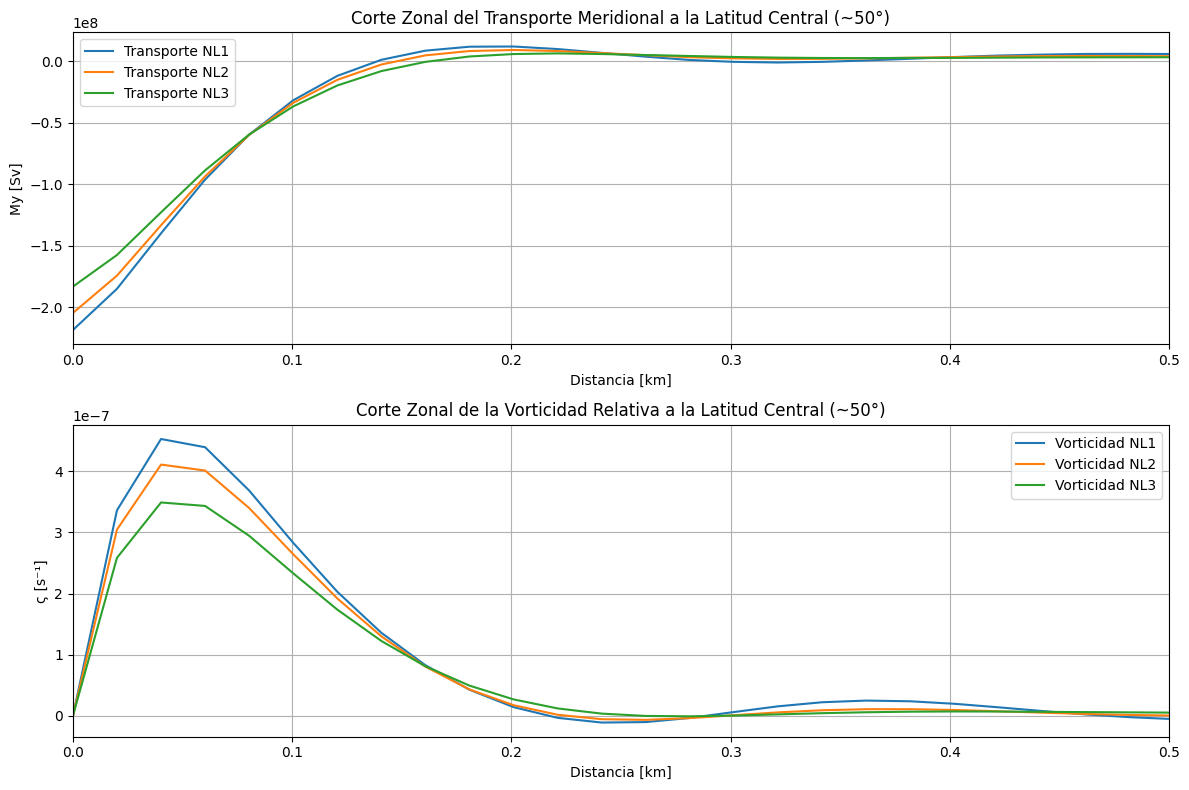

In [9]:
for idx, (nombre, dir_salida) in enumerate(dir_salidas.items()):
    datos_modelo = cargar(dir_salida, 4000, 2000, 200, 100)
    psiF = datos_modelo[2]  # Función corriente en el tiempo final
    vortF = datos_modelo[3]  # Vorticidad en el tiempo final
    X, Y = datos_modelo[6], datos_modelo[7]  # Coordenadas X y Y

# Escoger la latitud central
lat_central_idx = Y.shape[0] // 2  # Índice de la latitud central

# Crear una figura para los gráficos
plt.figure(figsize=(12, 8))

# Graficar el corte zonal del transporte meridional
plt.subplot(2, 1, 1)
for nombre, dir_salida in dir_salidas.items():
    datos_modelo = cargar(dir_salida, 4000, 2000, 200, 100)
    psiF = datos_modelo[2]  # Función corriente en el tiempo final
    vortF = datos_modelo[3]  # Vorticidad en el tiempo final
    X, Y = datos_modelo[6], datos_modelo[7]  # Coordenadas X y Y

    # Dimensionalización de las variables ya calculadas
    psi_dim = psiF * U * L
    trans_mer_dim = np.diff(psi_dim, n=1, axis=1) * D  # Calcular el transporte meridional dimensional

    # Extraer el corte zonal en la latitud central
    corte_zonal_trans_mer = trans_mer_dim[lat_central_idx, :]
    
    # Graficar
    plt.plot(X[:-1] / 1000, corte_zonal_trans_mer, label=f'Transporte {nombre}')

plt.title(f'Corte Zonal del Transporte Meridional a la Latitud Central (~{lat_central_idx}°)')
plt.xlim([0, 0.5])
plt.xlabel('Distancia [km]')
plt.ylabel('My [Sv]')
plt.legend()
plt.grid(True)

# Graficar el corte zonal de la vorticidad relativa
plt.subplot(2, 1, 2)
for nombre, dir_salida in dir_salidas.items():
    datos_modelo = cargar(dir_salida, 4000, 2000, 200, 100)
    vortF = datos_modelo[3]  # Vorticidad en el tiempo final
    X, Y = datos_modelo[6], datos_modelo[7]  # Coordenadas X y Y

    # Dimensionalizar la vorticidad relativa
    vort_dim = vortF * U / L

    # Extraer el corte zonal en la latitud central
    corte_zonal_vort = vort_dim[lat_central_idx, :]

    # Graficar
    plt.plot(X / 1000, corte_zonal_vort, label=f'Vorticidad {nombre}')
    

plt.title(f'Corte Zonal de la Vorticidad Relativa a la Latitud Central (~{lat_central_idx}°)')
plt.xlim([0, 0.5])
plt.xlabel('Distancia [km]')
plt.ylabel('ς [s⁻¹]')
plt.legend()
plt.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [10]:
def analizar_simulacion(dir_salida, U, L, D):
    # Cargar los datos de la simulación
    datos_modelo = cargar(dir_salida, 4000, 2000, 200, 100)
    psiF = datos_modelo[2]  # Función corriente en el tiempo final
    X = datos_modelo[6]  # Coordenadas X
    
    # Calcular los parámetros requeridos usando la función Calc_TrasMer_CBO_LatCent
    Limite_CBO_LatCent, TrasMer_CBO_LatCent, TrasMer_total_LatCent = Calc_TrasMer_CBO_LatCent(X, psiF, U, L, D)
    
    return Limite_CBO_LatCent, TrasMer_CBO_LatCent, TrasMer_total_LatCent

In [11]:
# Diccionario para almacenar los resultados de cada simulación
resultados = {}

# Realizar los cálculos para cada simulación
for nombre, dir_salida in dir_salidas.items():
    limite_CBO, trasMer_CBO, trasMer_total = analizar_simulacion(dir_salida, U, L, D)
    resultados[nombre] = {
        'Limite_CBO_LatCent': limite_CBO,
        'TrasMer_CBO_LatCent': trasMer_CBO,
        'TrasMer_total_LatCent': trasMer_total
    }

# Mostrar resultados
for nombre, valores in resultados.items():
    print(f"Resultados para {nombre}:")
    print(f"  Extensión zonal de la CBO a la latitud central: {valores['Limite_CBO_LatCent']:.2f} km")
    print(f"  Transporte meridional de la CBO a la latitud central: {valores['TrasMer_CBO_LatCent']:.2f} Sv")
    print(f"  Transporte meridional total a la latitud central: {valores['TrasMer_total_LatCent']} Sv\n")

Resultados para NL1:
  Extensión zonal de la CBO a la latitud central: 140.70 km
  Transporte meridional de la CBO a la latitud central: -741.49 Sv
  Transporte meridional total a la latitud central: 2.3422762751579283e-13 Sv

Resultados para NL2:
  Extensión zonal de la CBO a la latitud central: 160.80 km
  Transporte meridional de la CBO a la latitud central: -712.07 Sv
  Transporte meridional total a la latitud central: -8.796341717243195e-13 Sv

Resultados para NL3:
  Extensión zonal de la CBO a la latitud central: 180.90 km
  Transporte meridional de la CBO a la latitud central: -672.38 Sv
  Transporte meridional total a la latitud central: -1.6763806343078614e-13 Sv

